## Index

1. [Importing Libraries](#L1)
<br/><br/>
2. [Utility Functions](#L2)
<br/><br/>
3. [Set working directory](#L3)
<br/><br/>
5. [Read the entire image dataset](#L4)
<br/><br/>
6. [Subset the image dataset](#L5)
    - 5.1. [Train - EachClass=10, Test - 100, RGB](#L5.1)
    - 5.2. [Train - EachClass=10, Test - 100, GREY_SCALE](#L5.2)
    - 5.3. [Train - EachClass=10, Test - 100, RGB, SHRINKED](#L5.3)
    - 5.4. [Train - EachClass=10, Test - 100, GREY_SCALE, SHRINKED](#L5.4)
<br/><br/>

<span style="color:#337AFF;font-size:18px;font-weight:bold;">1. Importing Libraries</span>

Library for ignoring warnings while importing Libraries, Deprecation Warnings etc..

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
from IPython import display
import time
import shutil
import logging
import datetime

In [4]:
import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [7]:
from PIL import Image

In [8]:
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D,ZeroPadding2D, Dense, Dropout, Activation, Flatten
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values

Using TensorFlow backend.


In [9]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.utils import to_categorical
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.layers import BatchNormalization
from keras.models import model_from_json

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [11]:
logging.basicConfig(filename='CNNCapstoneLog.log',level=logging.DEBUG)
ts = datetime.datetime.now()
logging.info("******************************************************************")
logging.info("Execution started at - "+ts.strftime("%Y-%m-%d %H:%M:%S"))

[Click here to go to top](#TOP).

<span style="color:#337AFF;font-size:18px;font-weight:bold;">2. Utility Functions </span>

<a id='L2.1'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.1. Func - Set Working Directory Path</span>

In [12]:
def fun_SetWorkingDirectoryPath(directoryPath):
    os.chdir(directoryPath)

<a id='L2.2'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.2. Func - Delete Working Directory</span>

In [13]:
def fun_DeleteWorkingDirectory(working_dir_path):
    if os.path.exists(working_dir_path):
        shutil.rmtree(working_dir_path)
        logging.info("Deleted Working Directory")
        print("Deleted Working Directory Successfully !")
    else:
        logging.error("Directory Doesn't Exist")
        print("Directory Doesn't Exist !")
    print("")

<a id='L2.3'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.3. Func - Create Working Directory</span>

In [14]:
def fun_CreateWorkingDirectories(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        logging.info(directory + "  -  Created !")
        print(directory + "  -  Created !")
    print("")

<a id='L2.4'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.4. Func - Recursive List Files</span>

In [15]:
def fun_GetFilesList(directoryPath):
    files_list = []
    for root, directories, filenames in os.walk(directoryPath):
        for filename in filenames:
            iterImage = filename.upper()
            if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
                files_list.append(os.path.join(root,filename))
    
    return(files_list)

<a id='L2.5'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.5. Func - Convert File_Images_List to Arrays</span>

In [16]:
def fun_ConvertImagesToArray(readFile, imageFilesList):
    imageFileArray = []
    filesReadCount = 0
    #for tempImages in imageFilesList:
    logging.debug("Reading {0} images :".format(readFile))
    print("Reading {0} images :".format(readFile))
    for tempImages in log_progress(imageFilesList, every=1):
        iterImage = tempImages.upper()
        if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
            tempArray = np.array(Image.open(tempImages))
            if (len(tempArray.shape))==2:
                tempShape = tempArray.shape
                tempArray = tempArray.reshape(tempShape[0], tempShape[1], 1)
            imageFileArray.append(tempArray)
            filesReadCount = filesReadCount + 1
    print("")
        
    return(np.asarray(imageFileArray))

<a id='L2.6'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.6. Func - Generate Labels from File Names</span>

In [17]:
def fun_GetLabelsFromFileNames(entire_images_list):
    Y_Master = []
    for image_name in entire_images_list:
        try:
            temp = image_name.split("/")
            Y_Master.append(int(temp[len(temp)-2][1]))
        except:
            continue
    return(Y_Master)

<a id='L2.7'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.7. Func - Convert Images to Grey Scale and Save Them</span>

In [18]:
def fun_ConvertImages(source_dir_path,working_dir_path,readFile, imageFilesList, resizeHeight=None, resizeWidth=None, isGrayScaledConversion=False):
    imageFileArray = []
    filesReadCount = 0
    print("Converting {0} to the desired format :".format(readFile))
    for tempImages in log_progress(imageFilesList, every=1):
        iterImage = tempImages.upper()
        if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
            image=Image.open(tempImages)
            
            if (resizeHeight is not None and resizeWidth is not None):
                image = image.resize((resizeHeight, resizeWidth))

            if (isGrayScaledConversion):
                image=image.convert('L')

            #temp = tempImages.replace("Complete Dataset", "Working Dir")
            temp = tempImages.replace(source_dir_path, working_dir_path)
            
            image.save(temp)
            imageFileArray.append(temp)
            filesReadCount = filesReadCount + 1
            
    return (readFile, imageFileArray)

<a id='L2.8'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.8. Func - Frame X_Train and Y_Train</span>

In [19]:
def fun_oneHotEncode(labels, num_classes):
    values = np.array(labels)
    onehot_encoder = OneHotEncoder(sparse=False)
    values=values.reshape(len(values), 1)
    onehot_encoded = to_categorical(values)
    return onehot_encoded

In [20]:
def fun_Get_X_Y_Date(source_dir_path, working_dir_path, is_train, total_number_of_records, test_percentage, is_gray_scaled, resizeHeight, resizeWidth, num_classes):
    train_test_path = "";
    
    if(is_train):
        train_test_path = "/imgs/train/"
    else:
        train_test_path = "/imgs/test/"
    
    fun_Delete_And_Create_Working_Dir(working_dir_path, is_train, train_test_path)
    
    entire_images_list = []
    print(source_dir_path + train_test_path)
    entire_images_list = fun_GetFilesList(source_dir_path + train_test_path)
    print("(entire_images_list) {0}:".format(len(entire_images_list)))
    
    entire_labels_list = []
    if(is_train):
        entire_labels_list = fun_GetLabelsFromFileNames(entire_images_list)
        print("(entire_labels_list) {0} :".format(len(entire_labels_list)))
    else:
        entire_labels_list = np.full(np.array(entire_images_list).shape, 100)
        
    
    filePath_Labels_List_df = pd.DataFrame(
                                            {
                                                'Files_Path': entire_images_list,
                                                'Labels'    : entire_labels_list
                                            }
    )

    train_test_filePath_Labels_List_df = filePath_Labels_List_df.sample(n=total_number_of_records, random_state=10)
    
    if(is_train):
        for i in range(num_classes):
            print("(Label, Number of Rows) : ({0}, {1})".format(i, len(train_test_filePath_Labels_List_df[train_test_filePath_Labels_List_df["Labels"]==i])))
            print("")
            
    train_test_filePath_Labels_List_df.sample(frac=1, random_state=10)
    
    X_train, X_test, Y_train, Y_test = (train_test_split(
                                                train_test_filePath_Labels_List_df["Files_Path"], 
                                                train_test_filePath_Labels_List_df["Labels"], 
                                                test_size = test_percentage,
                                                random_state = 10
                                            )
                                   )
    print("(X_train, Y_train) : ({0}, {1})".format(len(X_train), len(Y_train)))
    print("(X_test, Y_test)   : ({0}, {1})".format(len(X_test), len(Y_test)))
    print("")

    (readFile, imageFileArray) = fun_ConvertImages(
                            source_dir_path + train_test_path,
                            working_dir_path + train_test_path,
                            readFile="X_train",
                            imageFilesList=X_train, 
                            resizeHeight=resizeHeight, 
                            resizeWidth=resizeWidth, 
                            isGrayScaledConversion=is_gray_scaled
                    )
    X_train = fun_ConvertImagesToArray(
                   readFile,
                   imageFileArray
              )
    
    X_train = X_train.astype('float32') 
    #Y_train = Y_train.astype('float32') 
    
    # Normalise data to [0, 1] range
    X_train /= np.max(X_train)
    #Y_train /= np.max(Y_train)
    
    #Y_train = np_utils.to_categorical(Y_train, num_classes) # One-hot encode the labels
    
    # One-hot encode the train labels
    #Y_train = fun_oneHotEncode(Y_train)
    Y_train_oneHot = fun_oneHotEncode(Y_train, num_classes)
    
    
    print("(X_train.shape, Y_train.shape) : ({0}, {1})".format(X_train.shape, Y_train.shape))
    
    if(len(X_test) is not 0):
        (readFile, imageFileArray) = fun_ConvertImages(
                                source_dir_path + train_test_path,
                                working_dir_path + train_test_path,
                                readFile="X_test",
                                imageFilesList=X_test, 
                                resizeHeight=resizeHeight, 
                                resizeWidth=resizeWidth, 
                                isGrayScaledConversion=is_gray_scaled
                        )
        X_test  = fun_ConvertImagesToArray(
                       readFile,
                       imageFileArray
                  )
        
        X_test = X_test.astype('float32') 
        #Y_test = Y_test.astype('float32')
    
        # Normalise data to [0, 1] range
        X_test /= np.max(X_test)
        #Y_test /= np.max(Y_test)
        
        #Y_test = np_utils.to_categorical(Y_test, num_classes) # One-hot encode the labels
        
        # One-hot encode the test labels
        #Y_test = fun_oneHotEncode(Y_test, num_classes)
        Y_test_oneHot = fun_oneHotEncode(Y_test, num_classes)
        
        print("(X_test.shape, Y_test.shape) : ({0}, {1})".format(X_test.shape, Y_test.shape))    
    
        
    print("")        
    
    num_train, height, width, depth = X_train.shape
    inp = Input(shape=(height, width, depth)) # N.B. depth goes first in Keras!
                                       
    #return (X_train, X_test, Y_train, Y_test, num_train, height, width, depth, inp, train_test_filePath_Labels_List_df)
    return (X_train, X_test, Y_train, Y_train_oneHot, Y_test, Y_test_oneHot, num_train, height, width, depth, inp, train_test_filePath_Labels_List_df)

<a id='L2.9'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.9. Func - Delete and Create Working Directory</span>

In [21]:
def fun_Delete_And_Create_Working_Dir(working_dir_path, is_train, train_test_path):
    dir_path = working_dir_path + train_test_path
    print("direcory path", dir_path)
    
    fun_DeleteWorkingDirectory(dir_path)
        
    if(is_train):
        for i in range(0,10):
            fun_CreateWorkingDirectories(dir_path + "c" + str(i))
    else:
        fun_CreateWorkingDirectories(dir_path)

<a id='L2.10'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.10. Func - Progress Bar</span>

In [22]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

<a id='L2.11'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.11. Func - Frame Convolutional Layers</span>

In [23]:
def fun_FrameConvolutionalLayers(prev_c_mp_dp_layer, no_of_filters, c_filter_dim, c_stride_dim, activation, mp_dim, mp_stride, drop_prob):
    conv_layer    = Convolution2D(filters = no_of_filters, kernel_size = (c_filter_dim, c_filter_dim), strides = (c_stride_dim, c_stride_dim), activation=activation)(prev_c_mp_dp_layer)
    max_pol_layer = MaxPooling2D(pool_size=(mp_dim, mp_dim), strides=(mp_stride, mp_stride))(conv_layer)
    dropout_layer = Dropout(drop_prob)(max_pol_layer)
    logging.debug("conv_layer    = Convolution2D(filters = no_of_filters, kernel_size = (c_filter_dim, c_filter_dim), strides = (c_stride_dim, c_stride_dim), activation=activation)(prev_c_mp_dp_layer)")
    logging.debug("max_pol_layer = MaxPooling2D(pool_size=(mp_dim, mp_dim), strides=(mp_stride, mp_stride))(conv_layer)")
    logging.debug("dropout_layer = Dropout(drop_prob)(max_pol_layer)")
    logging.debug(prev_c_mp_dp_layer, no_of_filters, c_filter_dim, c_stride_dim, activation, mp_dim, mp_stride, drop_prob)
    print("conv_layer    = Convolution2D(filters = no_of_filters, kernel_size = (c_filter_dim, c_filter_dim), strides = (c_stride_dim, c_stride_dim), activation=activation)(prev_c_mp_dp_layer)")
    print("max_pol_layer = MaxPooling2D(pool_size=(mp_dim, mp_dim), strides=(mp_stride, mp_stride))(conv_layer)")
    print("dropout_layer = Dropout(drop_prob)(max_pol_layer)")
    print(prev_c_mp_dp_layer, no_of_filters, c_filter_dim, c_stride_dim, activation, mp_dim, mp_stride, drop_prob)
    
    return(dropout_layer)

<a id='L2.12'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.12. Func - Frame Dense Layers</span>

In [24]:
def fun_FrameDenseLayers(flatten_layer, layer_size, activation, drop_prob):
    hidden_layer  = Dense(layer_size, activation=activation)(flatten_layer)
    dropout_layer = Dropout(drop_prob)(hidden_layer)
    
    return(dropout_layer)

<a id='L2.13'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.13. Func - Read Convolutional Layer Definitions</span>

In [25]:
def fun_ReadConvolutionLayerDefinitions(excelFileName, sheetName):
    convolution_definitions = pd.read_excel(excelFileName, sheet_name=sheetName,header=1)
    convolution_definitions
    logging.debug("Total Groups in Convolutional Layer: " + str(len(convolution_definitions["Group"].value_counts())))
    print("Total Groups in Convolutional Layer: " + str(len(convolution_definitions["Group"].value_counts())))
    print("")
    
    return(convolution_definitions)

<a id='L2.14'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.14. Func - Read Dense Layer Definitions</span>

In [26]:
def fun_ReadDenseLayerDefinitions(excelFileName, sheetName):
    dense_definitions = pd.read_excel(excelFileName, sheet_name=sheetName)
    logging.debug("Total Groups in Dense Layer: " + str(len(dense_definitions["Group"].value_counts())))
    print("Total Groups in Dense Layer: " + str(len(dense_definitions["Group"].value_counts())))
    print("")
    
    return(dense_definitions)

<a id='L2.15'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.15. Func - Compile and Fit Model</span>

In [27]:
def fun_CompileAndFitModel(cnn_output_df, loss, optimizer, metrics, X_train, Y_train, X_test, Y_test, batch_size, num_epochs, validation_split):
    
    cnn_output_df["loss"] = ""
    cnn_output_df["accuracy"] = ""
    for index_cnn, row_cnn in cnn_output_df.iterrows():
        model = row_cnn["conv_dense_layer"]
        
        logging.debug("Processing Group-{0}".format(row_cnn["group_id"]))
        print("Processing Group-{0}".format(row_cnn["group_id"]))
        model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
        model.fit(
                    X_train, 
                    Y_train,
                    batch_size=batch_size,
                    nb_epoch=num_epochs,
                    verbose=1, 
                    validation_split=validation_split
        )
        row_cnn["conv_dense_layer"] = model
        scores=model.evaluate(X_test, fun_oneHotEncode(Y_test), verbose=1)
        row_cnn["loss"] = scores[0]
        row_cnn["accuracy"] = scores[1] * 100
        logging.debug("Accuracy is: {0}".format(row_cnn["accuracy"]*100))
        print("Accuracy is: {0}".format(row_cnn["accuracy"]))
        print("")
        print("")
    
    return(cnn_output_df)

<a id='L2.16'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.16. Func - Evaluate Model</span>

In [28]:
def fun_EvaluateModel(model):
    return(model.evaluate(X_test, Y_test, verbose=1))

<a id='L2.17'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.17. Func - Print Model Summary</span>

In [29]:
def fun_PrintModelSummary(model):
    return(model.summary())

<a id='L2.18'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.18. Func - Generate Convolutional Layers</span>

In [30]:
def fun_GenerateConvolutions(convolutional_layers):
    temp_group_value = None
    final_layer      = None
    conv_layer_list  = []
    conv_group_list  = []
    model = None

    for index, row in convolutional_layers.iterrows():
        if(row["Is_Active"]=="Y"):
        
            if(temp_group_value != row["Group"]):
                print("")
                logging.debug("Processing Convolutional Group-{0}".format(row["Group"]))
                print("Processing Convolutional Group-{0}".format(row["Group"]))
                temp_group_value = row["Group"]
                paddingVal="Same"
                mppaddingVal="Same"
                if row["c_padding_no"]==0:
                    paddingVal="Valid"

                if row["mp_padding_no"]==0:
                    mppaddingVal="Valid"

                if(model is not None):
                    conv_group_list.append(int(row["Group"])-1)
                    model.add(Flatten())
                    conv_layer_list.append(model)

                model = Sequential()
                model.add(Conv2D(row["c_filter_no"], kernel_size=(row["c_filter_dim"], row["c_filter_dim"]),\
                                 strides=(row["c_stride_dim"], row["c_stride_dim"]), input_shape=(width, height, depth),\
                                 padding=paddingVal ,activation=row["activation"]))
            else:
                model.add(Conv2D(row["c_filter_no"], kernel_size=(row["c_filter_dim"], row["c_filter_dim"]),\
                                 strides=(row["c_stride_dim"], row["c_stride_dim"]), \
                                 padding=paddingVal, activation=row["activation"]))
            model.add(MaxPooling2D(pool_size=(row["mp_dim"], row["mp_dim"]), strides=(row["mp_stride"], row["mp_stride"]),\
                                  padding=mppaddingVal ))
            model.add(BatchNormalization())
            model.add(Dropout(row["drop_prob"]))
        
    conv_group_list.append(row["Group"])
    model.add(Flatten())
    conv_layer_list.append(model)

    conv_group_df = pd.DataFrame(
                                    {
                                        'group_id'  : conv_group_list,
                                        'conv_layer' : conv_layer_list
                                    }
    )
    print("")
    
    return(conv_group_df)
    

<a id='L2.19'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.19. Func - Generate Dense Layers</span>

In [31]:
def fun_GenerateDenses(convolutional_layers_df, dense_layers, num_classes):
    dense_layer_list = []
    dense_group_list  = []

    for index_conv, row_conv in convolutional_layers_df.iterrows():
        model = row_conv["conv_layer"]

        final_layer = None
        temp_dense_row_id = None
        
        for index_dense, row_dense in dense_layers.iterrows():
            if(row_dense["Is_Active"]):
                if(temp_dense_row_id != int(row_dense["Group"])):
                    if(temp_dense_row_id is not None):
                        model.add(Dense(num_classes, activation=row_dense["activation"]))
                        dense_group_list.append(str(row_conv["group_id"]) + "-" + str(row_dense["Group"]-1))
                        dense_layer_list.append(model)
                        print("")

                    temp_dense_row_id = int(row_dense["Group"])   
                    logging.debug("Processing Conv Group-{0}, Dense Group-{1}".format(row_conv["group_id"], row_dense["Group"]))
                    print("Processing Conv Group-{0}, Dense Group-{1}".format(row_conv["group_id"], row_dense["Group"]))

                model.add(Dense(row_dense["layer_size"], activation=row_dense["activation"]))
        
        dense_group_list.append(str(row_conv["group_id"]) + "-" + str(row_dense["Group"]))
        dense_layer_list.append(model)
        print("")
        
            
    dense_group_df = pd.DataFrame(
                                    {
                                        'group_id'         : dense_group_list,
                                        'conv_dense_layer' : dense_layer_list
                                    }
    )
    print("")
    
    return(dense_group_df)
    

<a id='L2.20'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.20. Func - Generate CNN Output Dataframe</span>

In [32]:
def fun_GenerateCNNOutputDataFrame(convolutional_layers, dense_layers, num_classes):
    convolutional_layers_df = fun_GenerateConvolutions(convolutional_layers)
    dense_layers_df = fun_GenerateDenses(convolutional_layers_df, dense_layers, num_classes)
    
    return(dense_layers_df)

<a id='L2.21'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.21. Func - Save Model</span>

In [33]:
def save_model(working_dir_path, model, index, cross=''):
    print(model)
    json_string = model.to_json()
    if not os.path.isdir(working_dir_path + '/cache'):
        os.mkdir(working_dir_path + '/cache')
    json_name = 'architecture' + str(index) + cross + '.json'
    weight_name = 'model_weights' + str(index) + cross + '.h5'
    open(os.path.join(working_dir_path + '/cache', json_name), 'w').write(json_string)
    print(working_dir_path + '/cache')
    model.save_weights(os.path.join(working_dir_path + '/cache', weight_name), overwrite=True)

<a id='L2.22'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.22. Func - Read Model</span>

In [34]:
def read_model(working_dir_path, index, cross=''):
    json_name = 'architecture' + str(index) + cross + '.json'
    weight_name = 'model_weights' + str(index) + cross + '.h5'
    model = model_from_json(open(os.path.join(working_dir_path + '/cache', json_name)).read())
    model.load_weights(os.path.join(working_dir_path + '/cache', weight_name),by_name=True)
    return model

<span style="color:#337AFF;font-size:18px;font-weight:bold;">3. Define Working Directory</span>

In [35]:
#fun_SetWorkingDirectoryPath("/Users/LeninSV/Desktop/LeninKumar SV/temp/")
#fun_SetWorkingDirectoryPath("/Users/LeninSV/Desktop/LeninKumar SV/ddtemp/Complete Dataset/imgs/train/")

In [36]:
source_dir_path = "/Users/deepa/Documents/Project/Complete Dataset/"

In [37]:
working_dir_path = "/Users/deepa/Documents/Project/Working Dir/"

[Click here to go to top](#TOP).

<span style="color:#337AFF;font-size:18px;font-weight:bold;">4. Converting Images to GreyScale Resized</span>

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Resizing from 480 / 640 ---> 480 / 480  (Width / Height)</span>

<span style="color:#337AFF;font-size:18px;font-weight:bold;">4.1. Frame Data</span>

In [38]:
source_dir_path

'/Users/deepa/Documents/Project/Complete Dataset/'

In [39]:
source_dir_path + "/imgs/train/"

'/Users/deepa/Documents/Project/Complete Dataset//imgs/train/'

In [40]:
(X_train, 
 X_test, 
 Y_train,
 Y_train_oneHot,
 Y_test, 
 Y_test_oneHot,
 num_train, 
 height, 
 width, 
 depth, 
 inp,
train_test_filePath_Labels_List_df_1) = fun_Get_X_Y_Date(
                        source_dir_path, 
                        working_dir_path,
                        is_train=True,
                        total_number_of_records=2000,
                        test_percentage=0.3,
                        is_gray_scaled=True, 
                        resizeHeight=224, 
                        resizeWidth=224, 
                        num_classes=10
        )

direcory path /Users/deepa/Documents/Project/Working Dir//imgs/train/
Deleted Working Directory Successfully !

/Users/deepa/Documents/Project/Working Dir//imgs/train/c0  -  Created !

/Users/deepa/Documents/Project/Working Dir//imgs/train/c1  -  Created !

/Users/deepa/Documents/Project/Working Dir//imgs/train/c2  -  Created !

/Users/deepa/Documents/Project/Working Dir//imgs/train/c3  -  Created !

/Users/deepa/Documents/Project/Working Dir//imgs/train/c4  -  Created !

/Users/deepa/Documents/Project/Working Dir//imgs/train/c5  -  Created !

/Users/deepa/Documents/Project/Working Dir//imgs/train/c6  -  Created !

/Users/deepa/Documents/Project/Working Dir//imgs/train/c7  -  Created !

/Users/deepa/Documents/Project/Working Dir//imgs/train/c8  -  Created !

/Users/deepa/Documents/Project/Working Dir//imgs/train/c9  -  Created !

/Users/deepa/Documents/Project/Complete Dataset//imgs/train/
(entire_images_list) 22424:
(entire_labels_list) 22424 :
(Label, Number of Rows) : (0, 216)

(Lab

VBox(children=(HTML(value=''), IntProgress(value=0, max=1400)))

Reading X_train images :


VBox(children=(HTML(value=''), IntProgress(value=0, max=1400)))


(X_train.shape, Y_train.shape) : ((1400, 224, 224, 1), (1400,))
Converting X_test to the desired format :


VBox(children=(HTML(value=''), IntProgress(value=0, max=600)))

Reading X_test images :


VBox(children=(HTML(value=''), IntProgress(value=0, max=600)))


(X_test.shape, Y_test.shape) : ((600, 224, 224, 1), (600,))



<a id='L5.2'></a>
<span style="color:Brown;font-size:15px;font-weight:bold;">Logistic Regression</span>

In [41]:
m_train = X_train.shape[0];
m_test = X_test.shape[0];
n_train =Y_train.shape[0];
print ("Number of training examples: m_train = " + str(m_train));
print ("Number of testing examples: m_test = " + str(m_test));
print ("Number of testing examples: n_train = " + str(n_train));

Number of training examples: m_train = 1400
Number of testing examples: m_test = 600
Number of testing examples: n_train = 1400


In [42]:
train_set_x_flatten = X_train.reshape(m_train, -1);
test_set_x_flatten = X_test.reshape(m_test, -1);


In [43]:
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape));
print ("train_set_y shape: " + str(Y_train.shape));
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape));
print ("test_set_y shape: " + str(Y_test.shape));
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]));

train_set_x_flatten shape: (1400, 50176)
train_set_y shape: (1400,)
test_set_x_flatten shape: (600, 50176)
test_set_y shape: (600,)
sanity check after reshaping: [0.15686275 0.25490198 0.1882353  0.0627451  0.23137255]


In [44]:
#X_train = np.reshape(X_train, (140, -1))

In [45]:
#X_test = np.reshape(X_test, (60, -1))

In [46]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(X_train.reshape(-1,1))
test_data = min_max_scaler.transform(X_test.reshape(-1,1))

In [47]:
from sklearn.linear_model  import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [48]:
model_name = "Logistic Regression"
model_type = "Normal"

In [49]:
logisticRegression = LogisticRegression()
logisticRegression = logisticRegression.fit(train_set_x_flatten, Y_train)
Y_predict = logisticRegression.predict(test_set_x_flatten)
model_score = logisticRegression.score(test_set_x_flatten, Y_test)

In [50]:
training_set_Score         = logisticRegression.score(train_set_x_flatten,Y_train)
test_set_prediction_score  = metrics.accuracy_score(Y_predict, Y_test)

In [51]:
print("Training Set Score          : ", training_set_Score)
print("Test Set (Prediction) Score : ", test_set_prediction_score)

Training Set Score          :  1.0
Test Set (Prediction) Score :  0.9433333333333334


In [52]:
comparision_dataFrame = (pd.DataFrame(
                                        columns=[
                                                    "Model_Name", 
                                                    "Model_Type",
                                                    "Training_Score", 
                                                    "Test_Prediction_Score"
                                        ]
                                    )
                        )

In [53]:
result_df = pd.DataFrame([[model_name, model_type, training_set_Score, test_set_prediction_score]], columns=comparision_dataFrame.columns)
comparision_dataFrame = comparision_dataFrame.append(result_df)

In [54]:
import seaborn as sn
import scikitplot as skplt
import matplotlib.pyplot as plt

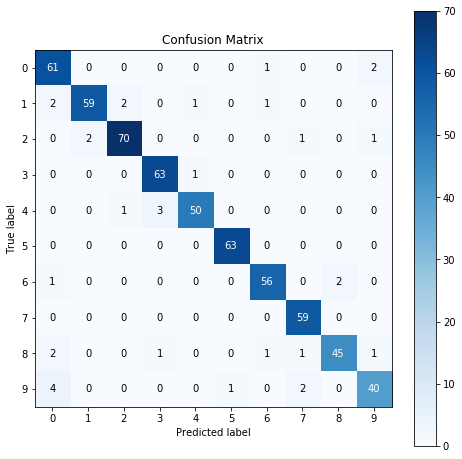

In [55]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(8,8))

In [56]:
Y_prob = logisticRegression.predict_proba(test_set_x_flatten)

/Users/deepa/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


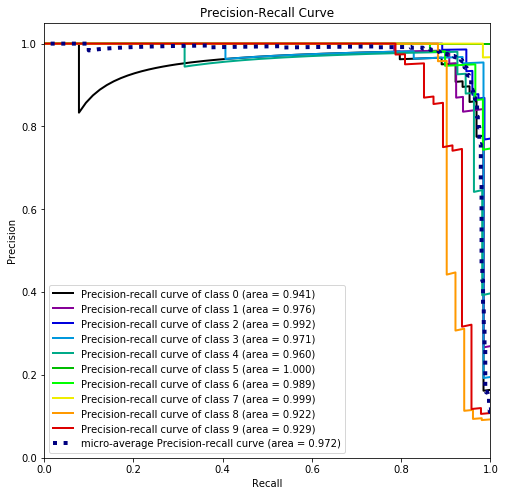

In [57]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_prob, figsize=(8,8))

In [282]:
## List of images to predict
input_images_list = fun_GetFilesList("/Users/deepa/Documents/Project/Complete Dataset/imgs/validate/")
logging.debug("(input_images_list) :".format(len(input_images_list)))
print("(input_images_list) :", len(input_images_list))

(input_images_list) : 2


In [283]:
(readFile, imageFileArray) = fun_ConvertImages(
                            source_dir_path + "/imgs/validate/",
                            working_dir_path + "/imgs/validate/",
                            readFile="Predict_Images",
                            imageFilesList=input_images_list, 
                            resizeHeight=224, 
                            resizeWidth=224, 
                            isGrayScaledConversion=True
                    )

Converting Predict_Images to the desired format :


VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

In [284]:
## Convert train images to Array
input_images = fun_ConvertImagesToArray(
                   readFile,
                   imageFileArray
              )
    
input_images = input_images.astype('float32') 

Reading Predict_Images images :


VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

In [285]:
validate_set_x_flatten = input_images.reshape(2, -1);

In [286]:
# Normalise data to [0, 1] range
input_images /= np.max(input_images)
    
logging.debug("(input_images) : ({0})".format(input_images.shape))
print("(input_images) : ({0})".format(input_images.shape))

(input_images) : ((2, 224, 224, 1))


In [287]:
Y_validate = logisticRegression.predict(validate_set_x_flatten)

In [288]:
Y_validate

array([2, 6])

In [289]:
def classValue(x):
    return {
        0: "Normal Driving",
        1: "Texting - right",
        2: "Talking on the phone - right",
        3: "Texting - left",
        4: "Talking on the phone - left",
        5: "Operating the radio",
        6: "Drinking",
        7: "Reaching behind",
        8: "Hair and makeup",
        9: "Talking to passenger"
    }[x]

In [297]:
vals=[]
classNames=[]
for val in Y_validate:
    print((val))
    vals.append((val))
    classNames.append(classValue((val)))

2
6


In [298]:
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import base64

In [299]:
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [300]:
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

In [301]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

In [302]:
input_images_list

['/Users/deepa/Documents/Project/Complete Dataset/imgs/validate/img_253.jpg',
 '/Users/deepa/Documents/Project/Complete Dataset/imgs/validate/img_251.jpg']

In [303]:
vals

[2, 6]

In [305]:
classNames

['Talking on the phone - right', 'Drinking']

In [306]:
predictions = pd.DataFrame(
                            {
                                'id':range(0,2),
                                'Image': input_images_list,
                                'Label': vals,
                                'Description': classNames
                            }
    )

predictions['dispimage'] = predictions.Image.map(lambda f: get_thumbnail(f))

In [307]:
pd.set_option('display.max_colwidth', -1)

,dispimage,Label,Description
0,,2,Talking on the phone - right
1,,6,Drinking

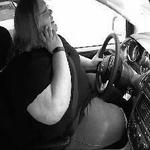
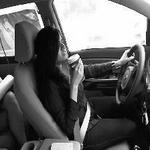

In [308]:
# displaying PIL.Image objects embedded in dataframe
HTML(predictions[['dispimage', 'Label', 'Description']].to_html(formatters={'dispimage': image_formatter}, escape=False))

#### Naive Bayes Classifier

In [192]:
model_name = "Naive Bayes Classifer"
model_type = "Normal"

In [193]:
naive_bayes = GaussianNB()
naive_bayes = naive_bayes.fit(train_set_x_flatten, Y_train.values.ravel())
Y_predict = naive_bayes.predict(test_set_x_flatten)
model_score = naive_bayes.score(test_set_x_flatten, Y_test)
Y_prob = naive_bayes.predict_proba(test_set_x_flatten)

In [194]:
training_set_Score         = naive_bayes.score(train_set_x_flatten,Y_train)
test_set_prediction_score  = metrics.accuracy_score(Y_predict, Y_test)

In [195]:
print("Training Set Score          : ", training_set_Score)
print("Test Set (Prediction) Score : ", test_set_prediction_score)

Training Set Score          :  0.5605714285714286
Test Set (Prediction) Score :  0.47


In [196]:
result_df = pd.DataFrame([[model_name, model_type, training_set_Score, test_set_prediction_score]], columns=comparision_dataFrame.columns)
comparision_dataFrame = comparision_dataFrame.append(result_df)

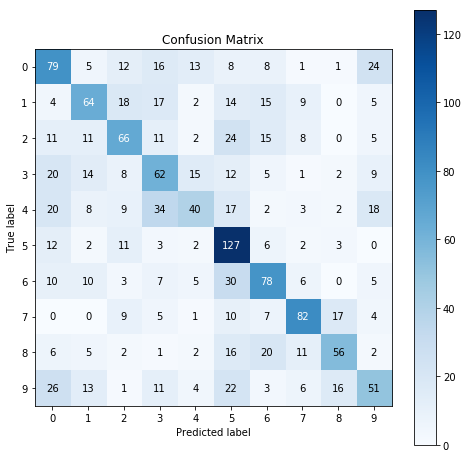

In [197]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(8,8))

/Users/deepa/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


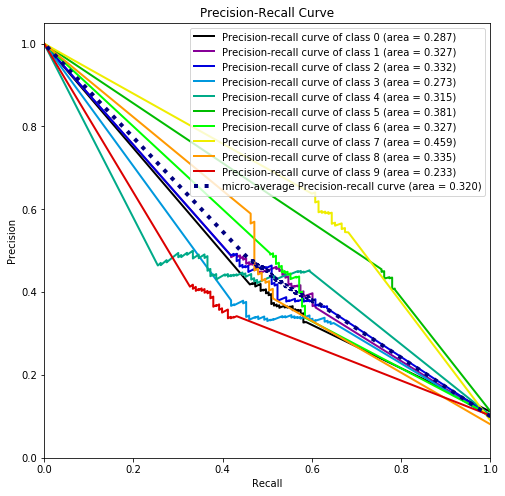

In [198]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_prob, figsize=(8,8))

#### Decision Tree Classifier

In [199]:
model_name = "Decision Tree Classifier"
model_type = "Normal"

In [200]:
for iter_max_depth in range(2,20):
    tree_model_2 = (DecisionTreeClassifier(
                                            criterion = 'entropy',
                                            max_depth = iter_max_depth
                                    )
                   )
    tree_model_fit_2 = tree_model_2.fit(train_set_x_flatten, Y_train)
    tree_model_predict_2 = tree_model_fit_2.predict(test_set_x_flatten)
    temp_accuracy_Score = accuracy_score(tree_model_predict_2, Y_test)
    # Accuracy
    print("Max_Depth_{0}, Accuracy Score : {1}".format(iter_max_depth, temp_accuracy_Score))
    df_confusion = (
                pd.crosstab(np.array(Y_test).flatten(),  tree_model_predict_2, 
                rownames=['Actual'],  colnames=['Predicted'])
    )

Max_Depth_2, Accuracy Score : 0.19066666666666668
Max_Depth_3, Accuracy Score : 0.236
Max_Depth_4, Accuracy Score : 0.268
Max_Depth_5, Accuracy Score : 0.2986666666666667
Max_Depth_6, Accuracy Score : 0.3413333333333333
Max_Depth_7, Accuracy Score : 0.374
Max_Depth_8, Accuracy Score : 0.44
Max_Depth_9, Accuracy Score : 0.4746666666666667
Max_Depth_10, Accuracy Score : 0.5066666666666667
Max_Depth_11, Accuracy Score : 0.524
Max_Depth_12, Accuracy Score : 0.5553333333333333
Max_Depth_13, Accuracy Score : 0.6073333333333333
Max_Depth_14, Accuracy Score : 0.6406666666666667
Max_Depth_15, Accuracy Score : 0.6573333333333333
Max_Depth_16, Accuracy Score : 0.6713333333333333
Max_Depth_17, Accuracy Score : 0.6793333333333333
Max_Depth_18, Accuracy Score : 0.67
Max_Depth_19, Accuracy Score : 0.6806666666666666


In [201]:
decisionTreeClassifier = DecisionTreeClassifier(criterion = 'entropy', max_depth=7)
decisionTreeClassifier = decisionTreeClassifier.fit(train_set_x_flatten, Y_train.values.ravel())
Y_predict = decisionTreeClassifier.predict(test_set_x_flatten)
model_score = decisionTreeClassifier.score(test_set_x_flatten, Y_test)
Y_prob = decisionTreeClassifier.predict_proba(test_set_x_flatten)

In [202]:
training_set_Score         = decisionTreeClassifier.score(train_set_x_flatten,Y_train)
test_set_prediction_score  = metrics.accuracy_score(Y_predict, Y_test)

In [203]:
print("Training Set Score          : ", training_set_Score)
print("Test Set (Prediction) Score : ", test_set_prediction_score)

Training Set Score          :  0.47285714285714286
Test Set (Prediction) Score :  0.38


In [204]:
result_df = pd.DataFrame([[model_name, model_type, training_set_Score, test_set_prediction_score]], columns=comparision_dataFrame.columns)
comparision_dataFrame = comparision_dataFrame.append(result_df)

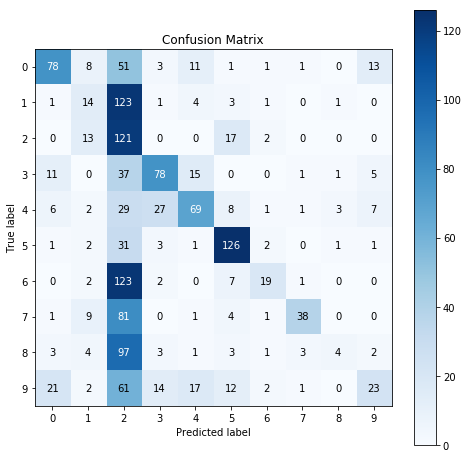

In [205]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(8,8))

/Users/deepa/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


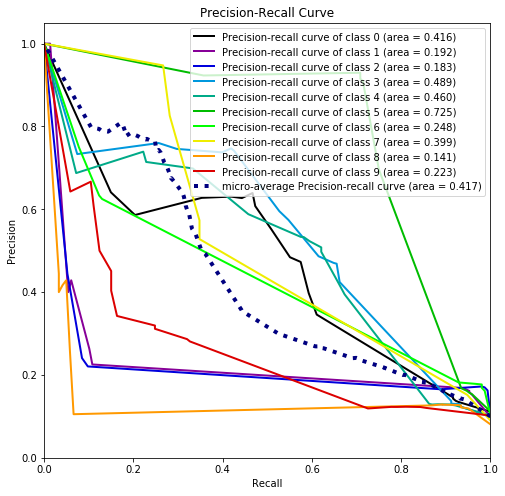

In [206]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_prob, figsize=(8,8))

#### KNN Classifier

In [207]:
model_name = "KNN Classifier"
model_type = "Normal"

In [208]:
kNeighborsClassifier = KNeighborsClassifier()
kNeighborsClassifier = kNeighborsClassifier.fit(train_set_x_flatten, Y_train.values.ravel())
Y_predict = kNeighborsClassifier.predict(test_set_x_flatten)
model_score = kNeighborsClassifier.score(test_set_x_flatten, Y_test)
Y_prob = kNeighborsClassifier.predict_proba(test_set_x_flatten)

In [209]:
training_set_Score         = kNeighborsClassifier.score(train_set_x_flatten,Y_train)
test_set_prediction_score  = metrics.accuracy_score(Y_predict, Y_test)

In [210]:
print("Training Set Score          : ", training_set_Score)
print("Test Set (Prediction) Score : ", test_set_prediction_score)

Training Set Score          :  0.9757142857142858
Test Set (Prediction) Score :  0.9546666666666667


In [211]:
result_df = pd.DataFrame([[model_name, model_type, training_set_Score, test_set_prediction_score]], columns=comparision_dataFrame.columns)
comparision_dataFrame = comparision_dataFrame.append(result_df)

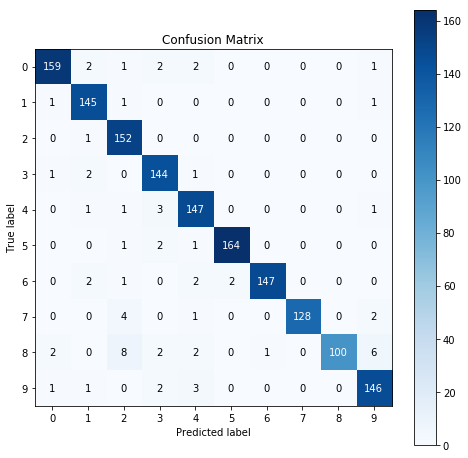

In [212]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(8,8))

/Users/deepa/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


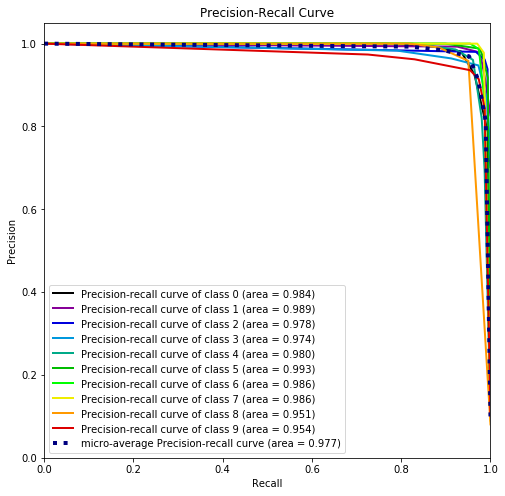

In [213]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_prob, figsize=(8,8))

#### Support Vector Machine Classifier

In [214]:
model_name = "Support Vector Machine Classifier"
model_type = "Normal"

support_vector = SVC()
support_vector = support_vector.fit(train_set_x_flatten, Y_train.values.ravel())
Y_predict = support_vector.predict(test_set_x_flatten)
model_score = support_vector.score(test_set_x_flatten, Y_test)
Y_prob = support_vector.predict_proba(test_set_x_flatten)

In [ ]:
training_set_Score         = support_vector.score(train_set_x_flatten,Y_train)
test_set_prediction_score  = metrics.accuracy_score(Y_predict, Y_test)

In [ ]:
print("Training Set Score          : ", training_set_Score)
print("Test Set (Prediction) Score : ", test_set_prediction_score)

In [ ]:
result_df = pd.DataFrame([[model_name, model_type, training_set_Score, test_set_prediction_score]], columns=comparision_dataFrame.columns)
comparision_dataFrame = comparision_dataFrame.append(result_df)

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(8,8))

In [ ]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_prob, figsize=(8,8))

#### Random Forest Classifier

In [216]:
model_name = "Random Forest Classifier"
model_type = "Ensemble"

In [217]:
randomForestClassifier = RandomForestClassifier(criterion = 'entropy', max_depth=12)
randomForestClassifier = randomForestClassifier.fit(train_set_x_flatten, Y_train.values.ravel())
Y_predict = randomForestClassifier.predict(test_set_x_flatten)
model_score = randomForestClassifier.score(test_set_x_flatten, Y_test)
Y_prob = randomForestClassifier.predict_proba(test_set_x_flatten)

In [218]:
training_set_Score         = randomForestClassifier.score(train_set_x_flatten,Y_train)
test_set_prediction_score  = metrics.accuracy_score(Y_predict, Y_test)

In [219]:
print("Training Set Score          : ", training_set_Score)
print("Test Set (Prediction) Score : ", test_set_prediction_score)

Training Set Score          :  0.9717142857142858
Test Set (Prediction) Score :  0.8306666666666667


In [220]:
result_df = pd.DataFrame([[model_name, model_type, training_set_Score, test_set_prediction_score]], columns=comparision_dataFrame.columns)
comparision_dataFrame = comparision_dataFrame.append(result_df)

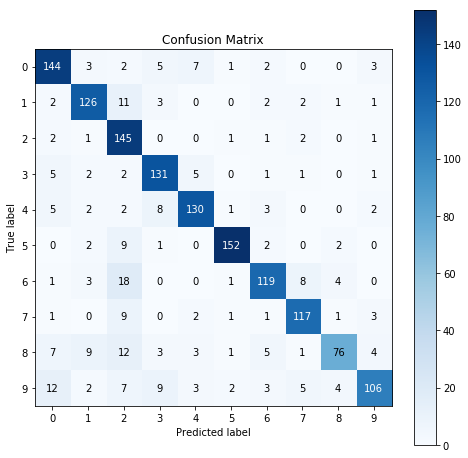

In [221]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(8,8))

/Users/deepa/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


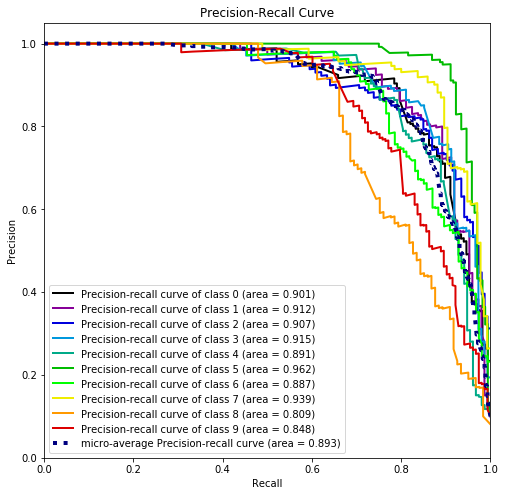

In [222]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_prob, figsize=(8,8))

##### <a id='L7.2'></a>
<span style="color:Brown;font-size:15px;font-weight:bold;"> Ada Boosting Classifier</span>

In [223]:
model_name = "Ada Boosting Classifier"
model_type = "Ensemble"

In [224]:
adb_regressor = AdaBoostClassifier()
adb_regressor = adb_regressor.fit(train_set_x_flatten, Y_train.values.ravel())
Y_predict = adb_regressor.predict(test_set_x_flatten)
model_score = adb_regressor.score(test_set_x_flatten, Y_test)
Y_prob = adb_regressor.predict_proba(test_set_x_flatten)

In [225]:
training_set_Score         = adb_regressor.score(train_set_x_flatten,Y_train)
test_set_prediction_score  = metrics.accuracy_score(Y_predict, Y_test)

In [226]:
print("Training Set Score          : ", training_set_Score)
print("Test Set (Prediction) Score : ", test_set_prediction_score)

Training Set Score          :  0.2988571428571429
Test Set (Prediction) Score :  0.25266666666666665


In [227]:
result_df = pd.DataFrame([[model_name, model_type, training_set_Score, test_set_prediction_score]], columns=comparision_dataFrame.columns)
comparision_dataFrame = comparision_dataFrame.append(result_df)

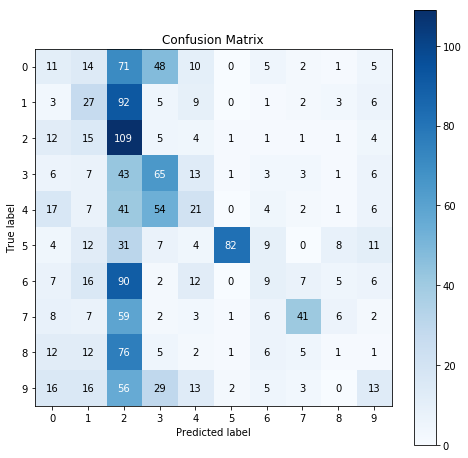

In [228]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(8,8))

/Users/deepa/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


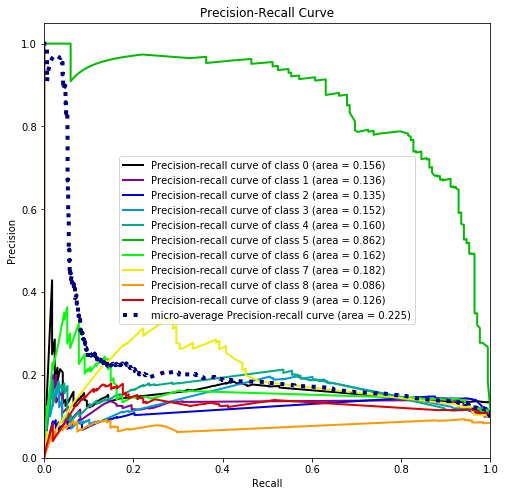

In [229]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_prob, figsize=(8,8))

#### <a id='L7.3'></a>
<span style="color:Brown;font-size:15px;font-weight:bold;">Bagging Classifier</span>

In [230]:
model_name = "Bagging Classifier"
model_type = "Ensemble"

In [231]:
baggingClassifier = BaggingClassifier()
baggingClassifier = baggingClassifier.fit(train_set_x_flatten, Y_train.values.ravel())
Y_predict = baggingClassifier.predict(test_set_x_flatten)
model_score = baggingClassifier.score(test_set_x_flatten, Y_test)
Y_prob = baggingClassifier.predict_proba(test_set_x_flatten)

In [232]:
training_set_Score         = baggingClassifier.score(train_set_x_flatten,Y_train)
test_set_prediction_score  = metrics.accuracy_score(Y_predict, Y_test)

In [233]:
print("Training Set Score          : ", training_set_Score)
print("Test Set (Prediction) Score : ", test_set_prediction_score)

Training Set Score          :  0.9994285714285714
Test Set (Prediction) Score :  0.852


In [234]:
result_df = pd.DataFrame([[model_name, model_type, training_set_Score, test_set_prediction_score]], columns=comparision_dataFrame.columns)
comparision_dataFrame = comparision_dataFrame.append(result_df)

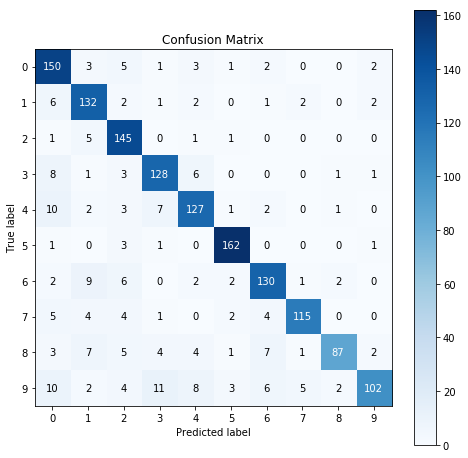

In [235]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(8,8))

/Users/deepa/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


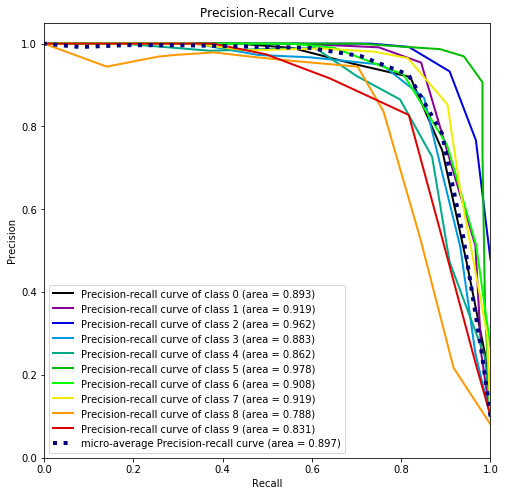

In [236]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_prob, figsize=(8,8))

#### <a id='L7.4'></a>
<span style="color:Brown;font-size:15px;font-weight:bold;">Ensembling Classifer</span>

In [237]:
model_name = "Voting Classifier"
model_type = "Ensemble"

In [238]:
logisticRegression = LogisticRegression()
naive_bayes = GaussianNB()
decisionTreeClassifier = DecisionTreeClassifier(criterion = 'entropy', max_depth=12)
kNeighborsClassifier = KNeighborsClassifier()
support_vector = SVC()
randomForestClassifier = RandomForestClassifier(criterion = 'entropy', max_depth=12)
adb_regressor = AdaBoostClassifier()
baggingClassifier = BaggingClassifier()

votingClassifier = (VotingClassifier(estimators = [('logisticRegression', logisticRegression), 
                                                   ('naive_bayes', naive_bayes), 
                                                   ('decisionTreeClassifier', decisionTreeClassifier), 
                                                   ('kNeighborsClassifier', kNeighborsClassifier),
                                                   ('support_vector', support_vector),
                                                   ('randomForestClassifier', randomForestClassifier),
                                                   ('adb_regressor', adb_regressor),
                                                   ('baggingClassifier', baggingClassifier)
                                                  ]
                                    )
                   )
votingClassifier = votingClassifier.fit(train_set_x_flatten, Y_train.values.ravel())
Y_predict = votingClassifier.predict(test_set_x_flatten)
model_score = votingClassifier.score(test_set_x_flatten, Y_test)
Y_prob = votingClassifier.predict_proba(test_set_x_flatten)

In [ ]:
training_set_Score         = votingClassifier.score(train_set_x_flatten,Y_train)
test_set_prediction_score  = metrics.accuracy_score(Y_predict, Y_test)

In [ ]:
print("Training Set Score          : ", training_set_Score)
print("Test Set (Prediction) Score : ", test_set_prediction_score)

In [ ]:
result_df = pd.DataFrame([[model_name, model_type, training_set_Score, test_set_prediction_score]], columns=comparision_dataFrame.columns)
comparision_dataFrame = comparision_dataFrame.append(result_df)

In [ ]:
comparision_dataFrame.index = list(range(1,len(comparision_dataFrame)+1))

In [244]:
(comparision_dataFrame
 .sort_values(
             by=['Training_Score', 'Test_Prediction_Score'], 
             inplace=True, 
             ascending=False
 )
)

comparision_dataFrame

,Model_Name,Model_Type,Training_Score,Test_Prediction_Score
1,Logistic Regression,Normal,1.000000,0.966667
7,Bagging Classifier,Ensemble,0.999429,0.852000
8,Voting Classifier,Ensemble,0.984857,0.894000
4,KNN Classifier,Normal,0.975714,0.954667
5,Random Forest Classifier,Ensemble,0.971714,0.830667
2,Naive Bayes Classifer,Normal,0.560571,0.470000
3,Decision Tree Classifier,Normal,0.472857,0.380000
6,Ada Boosting Classifier,Ensemble,0.298857,0.252667


In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_predict, figsize=(8,8))

In [ ]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_prob, figsize=(8,8))